<div style=background-color:#EEEEFF>

## 1. The Jokes Dataset

To train a joke-telling AI and test its performance, we need a dataset of jokes.  Here, we'll use the "One Million Reddit Jokes" dataset, which covers jokes from the /r/jokes subreddit from April 1, 2020 and earlier.  The jokes dataset is provided here in `./data/one-million-reddit-jokes.csv.`  You can also download the jokes dataset directly from Kaggle [here](https://www.kaggle.com/pavellexyr/one-million-reddit-jokes).

Let's start by reading in the jokes dataset, seeing what we have, and cleaning it up a little.

In [1]:
import pandas as pd

# Read in the raw jokes dataset
filename = '/opt/tljh/user/share/nlp_punchlines_data/one-million-reddit-jokes.csv'
raw_jokes = pd.read_csv(filename,keep_default_na=False)

# Print out the column names with a single example of the data in each column
print('{} jokes with the following columns (column name: example) '.format(raw_jokes.shape[0]))
for c in raw_jokes.columns:
    print('  {:>15}: {}'.format(c,raw_jokes.iloc[1][c]))

1000000 jokes with the following columns (column name: example) 
             type: post
               id: ftboup
     subreddit.id: 2qh72
   subreddit.name: jokes
   subreddit.nsfw: False
      created_utc: 1585785522
        permalink: https://old.reddit.com/r/Jokes/comments/ftboup/did_you_know_google_now_has_a_platform_for/
           domain: self.jokes
              url: 
         selftext: It's called Google Sheets.
            title: Did you know Google now has a platform for recording your bowel movements?
            score: 9


<div style=background-color:#EEEEFF>

Let's look at a few example rows from this dataset.

In [2]:
# Show the first three rows
raw_jokes.iloc[:3]

,type,id,subreddit.id,subreddit.name,subreddit.nsfw,created_utc,permalink,domain,url,selftext,title,score
0,post,ftbp1i,2qh72,jokes,False,1585785543,https://old.reddit.com/r/Jokes/comments/ftbp1i...,self.jokes,,My corona is covered with foreskin so it is no...,I am soooo glad I'm not circumcised!,2
1,post,ftboup,2qh72,jokes,False,1585785522,https://old.reddit.com/r/Jokes/comments/ftboup...,self.jokes,,It's called Google Sheets.,Did you know Google now has a platform for rec...,9
2,post,ftbopj,2qh72,jokes,False,1585785508,https://old.reddit.com/r/Jokes/comments/ftbopj...,self.jokes,,The vacuum doesn't snore after sex.\n\n&amp;#x...,What is the difference between my wife and my ...,15


<div style=background-color:#EEEEFF>

Of these columns, the only ones of relevence to us are the last 3: 
* `title` is usually used as the joke "setup"
* `selftext` stores the joke "punchline"
* `score` is the number of upvotes the joke received and can be used as a metric of "joke quality"

It would be nice if we could use `subreddit.nsfw` to filter out inappropriate jokes (crude, hyper-sexualized, racist, homophobic, sexist, or otherwise objectionable) but sadly `subreddit.nsfw = False` for everything in this dataset, despite that fact that many of the jokes are clearly NOT safe for work.  We'll discuss the problem of inappropriate jokes further later.

Here are the top 5 most common punchlines in our dataset:

In [3]:
# Show the value and the number counts for the 5 most common punchlines in the dataset
raw_jokes['selftext'].value_counts()[:5]

[removed]                    232921
[deleted]                    188442
                               4472
\[removed\]                     272
To get to the other side.       125
Name: selftext, dtype: int64

<div style=background-color:#EEEEFF>

Many of the jokes have been removed or deleted (maybe because they were inappropriate and the author or a moderator thought better of it?...).  We don't want these in our dataset.  
    
Some of them may be using the text "[removed]" as their actual punchline, in a self-referential meta joke about Reddit jokes.  We don't really want those either.
    
But what is going on with the jokes whose punchlines are blank?

In [4]:
pd.options.display.max_colwidth = None   # don't truncate the column text

# Get the jokes with blank punchlines (selftext=='')
#    Then show values & counts for the 5 most common setups
blank_punchline_counts = raw_jokes[raw_jokes['selftext']=='']['title'].value_counts()
blank_punchline_counts.rename_axis('title').reset_index(name='counts').set_index('counts')[:5]

,title
counts,
30,What do you get when you cross a joke with a rhetorical question?
27,Donald Trump
9,My life
9,Feminism
7,"A husband and wife are trying to set up a new password for their computer. The husband puts, ""Mypenis,"" and the wife falls on the ground laughing because on the screen it says, ""Error. Not long enough."""


<div style=background-color:#EEEEFF>

Okay, I get it.  Donald Trump is a joke.  My life is a joke.  Feminism is a joke.  Ha ha.

But this raises the larger issue that jokes can take many different narrative forms.  If we're hoping to get an AI to learn to tell jokes, we should start with a somewhat down-scoped problem. For this exercise, let's only use jokes that take the form of a "setup" question, followed by a "punchline" answer, e.g., 

* Question: Why did the chicken cross the road?
* Answer: To get to the other side.

In [13]:
# Clean up the jokes dataset:
#   - get rid of removed or deleted punchlines
#   - replace newlines w/ spaces (easier to read)
#   - require the setup to be a question
#   - remove blank punchlines (length < 1)

remove = ['[removed]','[deleted]','\[removed\]']   # We'll remove jokes with these punchlines
use_columns = ['title','selftext','score']  # We only care about these columns

jokes = raw_jokes[raw_jokes['selftext'].apply(lambda x: x not in remove)][use_columns]

# Rename columns, replace newlines with spaces
jokes = jokes.rename(columns={'title':'setup','selftext':'punchline'})
jokes['setup'] = jokes['setup'].apply(lambda x: x.replace('\n',' ').replace('\r',' '))
jokes['punchline'] = jokes['punchline'].apply(lambda x: x.replace('\n',' ').replace('\r',' '))

# Is the setup a question?
jokes['question'] = jokes['setup'].apply(lambda x: True if x[-1]=='?' else False)
# How long is the punchline?
jokes['punch_length'] = jokes['punchline'].apply(lambda x: len(x.split()))
# Only keep jokes with punchlines containing at least one word (some are all blank space)
jokes = jokes[jokes['punch_length'] >= 1]

print('{} jokes not missing punchlines, with the following columns:\n'.format(jokes.shape[0]))
for c in jokes.columns:
    print('  {:>15}: {}'.format(c,jokes.iloc[1][c]))

print('\n{} jokes have setups that are questions'.format(jokes[jokes['question']==True].shape[0]))

573847 jokes not missing punchlines, with the following columns:

            setup: Did you know Google now has a platform for recording your bowel movements?
        punchline: It's called Google Sheets.
            score: 9
         question: True
     punch_length: 4

204979 jokes have setups that are questions


<div style=background-color:#EEEEFF>

We probably also want to restrict ourselves to jokes with short(ish) punchlines---the longer we let an AI ramble on, the less sense it tends to make.

Let's look at the length of the punchlines for our jokes that are questions:

NOTE: logarithmic y-axis!


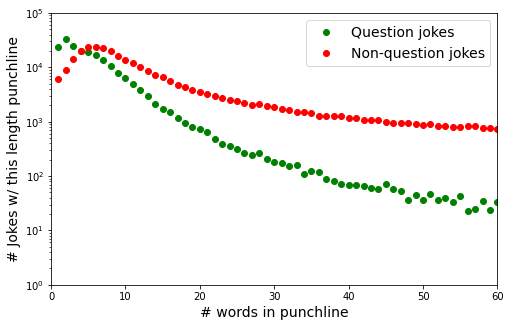

In [6]:
import matplotlib.pyplot as plt

print('NOTE: logarithmic y-axis!')
fig, ax = plt.subplots(1,1, figsize=(8,5))
plt.rcParams['font.size'] = '18'
ax.plot(list(jokes[jokes['question']==True]['punch_length'].value_counts().index),
        list(jokes[jokes['question']==True]['punch_length'].value_counts().values),
        'go', label='Question jokes')
ax.plot(list(jokes[jokes['question']==False]['punch_length'].value_counts().index),
        list(jokes[jokes['question']==False]['punch_length'].value_counts().values),
        'ro', label='Non-question jokes')
plt.yscale('log', nonpositive='clip')
ax.set_xlim((0,60))
ax.set_ylim((1,1e5))
_ = ax.set_xlabel('# words in punchline',size=14)
_ = ax.set_ylabel('# Jokes w/ this length punchline',size=14)
_ = ax.legend(fontsize=14)

<div style=background-color:#EEEEFF>

Question jokes tend to have short punchlines---typically just a few words long---whereas setups that are not questions often have a longer "narrative" format and a long tail of very long punchlines.  Note that the y-axis is logarithmic, so there are ~100x more very long punchlines in the non-question jokes than the question jokes.
    
Let's stick with "question" jokes that have short(ish) punchlines, no more than 20 words.

In [15]:
jokes = jokes[(jokes['question']==True) & (jokes['punch_length'] <= 20)]
print('{} Q/A jokes with short punchlines'.format(jokes.shape[0]))

197784 Q/A jokes with short punchlines


<div style=background-color:#EEEEFF>

Let's only keep jokes that *at least one* person thought were funny.

In [16]:
jokes = jokes[jokes['score'] >= 1]
print('{} Q/A jokes with short punchlines that got 1+ upvotes'.format(jokes.shape[0]))

153301 Q/A jokes with short punchlines that got 1+ upvotes


<div style=background-color:#EEEEFF>

And finally, some jokes get posted to Reddit again and again.  We want to deduplicate those, but we want to count *all* the upvotes received by the joke.  If we assume a Reddit user only sees and upvotes a joke once (rather than upvoting the same joke again and again), we can do that by summing the upvotes for each duplicate entry of a joke.

In [17]:
# Sum the scores for all jokes with the same setup and punchline
jokes['score'] = jokes.groupby(['setup', 'punchline'])['score'].transform('sum')
# Then drop the duplicate entries
jokes = jokes.drop_duplicates(subset=['setup','punchline'])
print('{} jokes in the final dataset'.format(jokes.shape[0]))

146796 jokes in the final dataset


<div style=background-color:#EEEEFF>

Let's split the jokes into a training set and a test set.  We'll use a fixed random seed so that we choose the same split each time.
    
We'll then write the jokes dataset to disk and take a look at some examples.

In [19]:
print('{:>10} jokes in our final dataset'.format(jokes.shape[0]))

train_frac = 0.7  # Use 70% of jokes for training, 30% for testing
seed = 40         # Use a fixed seed for random state so that we always get the same splits
mini_count = 300  # Let's also store a small subset of the test data as a "mini" test to use during development.

jokes_train = jokes.sample(frac=train_frac, axis=0, random_state=seed)
jokes_test = jokes[~jokes.index.isin(jokes_train.index)]

print('{:>10} jokes in our training set'.format(jokes_train.shape[0]))
print('{:>10} jokes in our test set'.format(jokes_test.shape[0]))

output_columns = ['setup','punchline','score']
outfile = 'data/short_jokes.csv'

print('Joke splits written to:')
for dset,name in [(jokes,'_all'), 
                  (jokes_train, '_train'),
                  (jokes_test,'_test'),
                  (jokes_test.iloc[:mini_count],'_minitest')]:
    dset[output_columns].to_csv(outfile.replace('.csv',name+'.csv'), header=True, index=False)
    print('{:>10} in {}'.format(dset.shape[0],outfile.replace('.csv',name+'.csv')))

    146796 jokes in our final dataset
    102757 jokes in our training set
     44039 jokes in our test set
Joke splits written to:
    146796 in data/short_jokes_all.csv
    102757 in data/short_jokes_train.csv
     44039 in data/short_jokes_test.csv
       300 in data/short_jokes_minitest.csv


In [20]:
print('\nHere are some examples:')
jokes_test.iloc[:10]


Here are some examples:


,setup,punchline,score,question,punch_length
1,Did you know Google now has a platform for recording your bowel movements?,It's called Google Sheets.,9,True,4
24,What do you call a boat full of dentists?,A tooth ferry,126,True,3
42,How do you know someone is feeling horny?,They click on this post,2,True,5
95,Why do you call your dog ”I-know-what-you-did”?,I love how many people jump 3 feet high when I start calling him.,14,True,14
194,Who led the digitization of your company?,1. CEO 2. CTO 3. COVID-19,5,True,6
237,what do you call a fish with no fins??,unfinished! and sad :(,3,True,4
259,What is Godzilla’s favorite cheese?,Gorgonzilla,5,True,1
262,What do you call a shy sponge?,Aloofa,2,True,1
331,Why are all the parents going cross-eyed during the quarantine?,They can't control their pupils.,5,True,5
374,What does Santa Claus say when he works in his garden?,Hoe Hoe Hoe!,1,True,3


In [21]:
print('\nAnd here are the top-10 scoring short Q/A-type jokes on Reddit:')
jokes_sorted = jokes.sort_values('score',ascending=False)
jokes_sorted.iloc[:10]


And here are the top-10 scoring short Q/A-type jokes on Reddit:


,setup,punchline,score,question,punch_length
108414,What did the reddit user say after detonating a bomb inside a bank?,EDIT: Wow! This blew up! Thanks for the gold!,93233,True,9
30021,Do you want to know why the republicans won't impeach Trump?,Because they believe in carrying a baby to full term.,72653,True,10
389332,What do you call it when two transgender midgets have sex?,Micro trans-action,68853,True,2
166123,Why was the anti-vaxxer‘s 4 year old child crying?,Midlife crisis,66729,True,2
345189,When does a joke become a dad joke?,When the punchline becomes apparent.,64480,True,5
184867,What's it called when a chameleon can't change its colors anymore?,A reptile dysfunction.,60284,True,3
230752,"If the Klu Klux Klan leaders are wizards, why don't they cast a spell to kill all those that oppose them?",Because they don't have access to black magic.,59936,True,8
600106,What is Gordon Ramsay's favorite subreddit?,"It's fucking r/aww edit: Fucking hell this blew up overnight. Thanks, you fuckin useless sacks of yankee dankee doodle shite",58804,True,20
132694,Why is girlfriend one word but best friend is two words?,Because your best friend gives you space when you need it.,57604,True,11
203833,Courtesy of my 6yo daughter: What do you call a dinosaur that takes care of its teeth?,A Flossiraptor,55697,True,2
